In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
from price import *
from kalman import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import dates

(CVXPY) May 02 11:10:29 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 02 11:10:29 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Import data
df = pd.read_csv('data/stock_price.csv', index_col = 0, header=[0,1])
sp500 = pd.read_csv('data/sp500.csv')

In [3]:
close_price = df[['Adj Close']]
close_price.columns = close_price.columns.droplevel(0)
volume = df[['Volume']]
volume.columns = volume.columns.droplevel(0)
# close_price

In [195]:
actual_R_mat = close_price.pct_change()
actual_R_mat = actual_R_mat[1:]

return_matrix = close_price.pct_change().shift(0)

In [5]:
train_period = 0.2

In [6]:
# Prediction using Kalman Filter
res1 = pd.DataFrame()
res2 = pd.DataFrame()
for fid in tqdm(close_price.columns):
#     print(fid)
    temp_close = close_price[fid]
    temp_volume = volume[fid]
    data = pd.DataFrame({'target':temp_close.shift(-1)/temp_close-1,'return':temp_close/temp_close.shift()-1,'return_vol':temp_volume/temp_volume.shift()-1})
    data.index = temp_close.index.values
    a = pd.DataFrame({fid:calc_kalman(data,train_period)})
    res1 = pd.concat([res1, a], axis = 1)
    a = pd.DataFrame({fid:calc_kalman_multi(data,train_period)})
    res2 = pd.concat([res2, a], axis = 1)

100%|██████████| 30/30 [03:35<00:00,  7.19s/it]


## Optimization Model

In [143]:
def NPM(r, his_r, x_tilde, theta, c):
    '''
    param r [ndarray]: vector of predicted return at period t
    param his_r [ndarray]: 2d vector of return for the past W periods; his_r[i][j] = price 
    param x_tilde [ndarray]: investment weights at the end of period t-1
    param theta [float]: acceptable risk level in the range of (0, 1), smaller theta could lead to infeasible solution
    param c [float]: transacion cost in the range of (0, 1)

    '''
    M = len(r) # Number of assets in the portfolio
    W = len(his_r) # Number of recents prices used to measure risk
    
    # Define variables
    u = cp.Variable(M)
    v = cp.Variable(M)
    d = cp.Variable(W)
    g = cp.Variable(W)
    
    # Define Objective
    objective = cp.Maximize(r @ x_tilde + (r - c/2) @ u - (r + c/2) @ v)
    
    # Define constraints
    constraints = [cp.sum(u - v) == 0,
                    -(u - v + x_tilde) <= 0,
                    u - v + x_tilde <= 1,
                    u >= 0, v >= 0, d >= 0, g >= 0]
    
    constraints += [cp.sum(d + g) <= W * theta]
    for j in range(W):
#         print('day', -1-j, np.sum(r - his_r[-1-j]))
        constraints += [(his_r[-1-j] - r) @ u - (his_r[-1-j] - r) @ v - d[j] <= (r - his_r[-1-j]) @ x_tilde,
                        (r - his_r[-1-j]) @ u - (r - his_r[-1-j]) @ v - g[j] <= (his_r[-1-j] - r) @ x_tilde]
        
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose = False, solver='ECOS_BB')
    if problem.status != cp.OPTIMAL:
        print('problem status', problem.status)
#     constraints_value = [constraint.value for constraint in constraints]
#     print(constraints_value)
        
    return problem, u.value, v.value, d.value, g.value

Algorithm

In [217]:
weight_mat = []
assets = close_price.columns
# assets =  assets[assets != 'NVDA']

pred_R_mat = res2
actual_R_mat = actual_R_mat 
N = len(pred_R_mat)
num_his = 6 # Number of historical days
init_weight = np.ones(len(assets)) / len(assets) # Start with uniform weight
theta = 0.05 # Risk level
c = 0.008 # Transaction Cost
start_day = pred_R_mat.iloc[:, 1].first_valid_index()
# print(start_day)
start_day = pred_R_mat.index.get_loc(start_day)

w = init_weight
# weight_mat.append(w)
for t in tqdm(range(start_day,N)):
    # In the paper, return is defined as pt/pt-1, so we should +1
    predicted_return = np.array((pred_R_mat+1).iloc[t][assets])
    historial_w_actual_returns = (actual_R_mat+1).iloc[t - num_his : t, :][assets]
    historial_w_actual_returns = historial_w_actual_returns.values
#     print('day', t)
    problem, u, v, d, g = NPM(predicted_return, historial_w_actual_returns, w, theta, c)
    w = w + u - v
#     w = NPM2(predicted_return, historial_w_actual_returns, w, theta, c)
#     u,v = NPM3(predicted_return, historial_w_actual_returns, w, theta, c)
#     w = w + u - v
    weight_mat.append(w)

100%|██████████| 2011/2011 [02:08<00:00, 15.67it/s]


Analyze the strategy

In [233]:
signal = pd.DataFrame(np.array(weight_mat), columns = assets, index = close_price.index[start_day : N])
signal

,AAPL,ABBV,ABT,AMZN,BA,BAC,C,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PFE,PG,T,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-24,1.159335e-11,1.024784e-11,1.075558e-11,1.285267e-11,1.079430e-11,1.063139e-11,1.074424e-11,1.120189e-11,4.670776e-11,1.241260e-11,...,1.258163e-11,2.648016e-11,9.196421e-12,1.363520e-11,1.474476e-11,1.311359e-11,1.071685e-11,1.215127e-11,1.280915e-11,1.344758e-11
2015-03-25,2.627040e-11,2.381887e-11,5.910401e-11,8.478759e-11,3.655428e-11,5.621154e-11,6.182069e-11,3.391532e-11,3.056489e-10,2.659632e-11,...,2.184504e-11,6.048315e-11,7.859823e-12,7.553290e-11,3.878128e-11,5.753086e-11,4.436287e-11,3.052937e-11,4.777603e-11,5.195435e-11
2015-03-26,4.317705e-11,5.326795e-11,6.124227e-11,6.428878e-11,5.560344e-11,5.308604e-11,4.549081e-11,1.598453e-11,7.601889e-11,5.729121e-11,...,3.924328e-11,3.343813e-11,2.952498e-11,3.590816e-11,4.691739e-11,5.367440e-11,4.634257e-11,5.510475e-11,5.037834e-11,4.720478e-11
2015-03-27,2.020402e-10,4.556877e-11,7.120363e-11,1.608621e-10,3.383168e-11,4.816889e-11,6.298511e-11,2.570050e-11,1.096939e-10,5.624973e-11,...,3.099419e-11,7.995108e-11,7.753762e-10,1.300452e-10,4.852367e-11,5.544020e-11,1.000000e+00,3.028618e-11,6.353589e-11,4.311457e-11
2015-03-30,1.128877e-10,7.392009e-11,8.654421e-11,1.021934e-10,1.409562e-10,9.032758e-11,9.098580e-11,1.020741e-10,9.941782e-11,9.383847e-11,...,8.298354e-11,9.698158e-11,1.743806e-10,1.036553e-10,8.636049e-11,8.885310e-11,1.000000e+00,8.801127e-11,8.833474e-11,9.282269e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13,1.979704e-11,1.000000e+00,1.455712e-11,5.080736e-11,2.471523e-11,9.241523e-12,5.440129e-12,1.989449e-11,1.519118e-11,8.421735e-12,...,1.808770e-09,1.601144e-11,1.462243e-10,3.355375e-11,3.896437e-11,1.936128e-11,1.534523e-11,1.088102e-11,1.646329e-11,2.310736e-11
2023-03-14,6.005032e-11,6.696566e-11,5.820369e-11,6.885935e-11,5.703776e-11,5.480165e-11,5.498727e-11,5.931849e-11,5.674548e-11,5.598485e-11,...,3.007915e-10,5.851866e-11,8.905707e-11,6.202512e-11,6.388803e-11,5.813360e-11,5.777917e-11,5.771248e-11,5.843619e-11,6.001198e-11
2023-03-15,4.283890e-11,4.091175e-11,3.696906e-11,1.026204e-10,3.572971e-11,3.898394e-11,3.367500e-11,4.442820e-11,3.323297e-11,3.820987e-11,...,1.928405e-10,3.921861e-11,2.256644e-10,3.892727e-11,4.172115e-11,3.641791e-11,3.844003e-11,3.478492e-11,3.966471e-11,4.005024e-11


Text(0, 0.5, 'Weight')

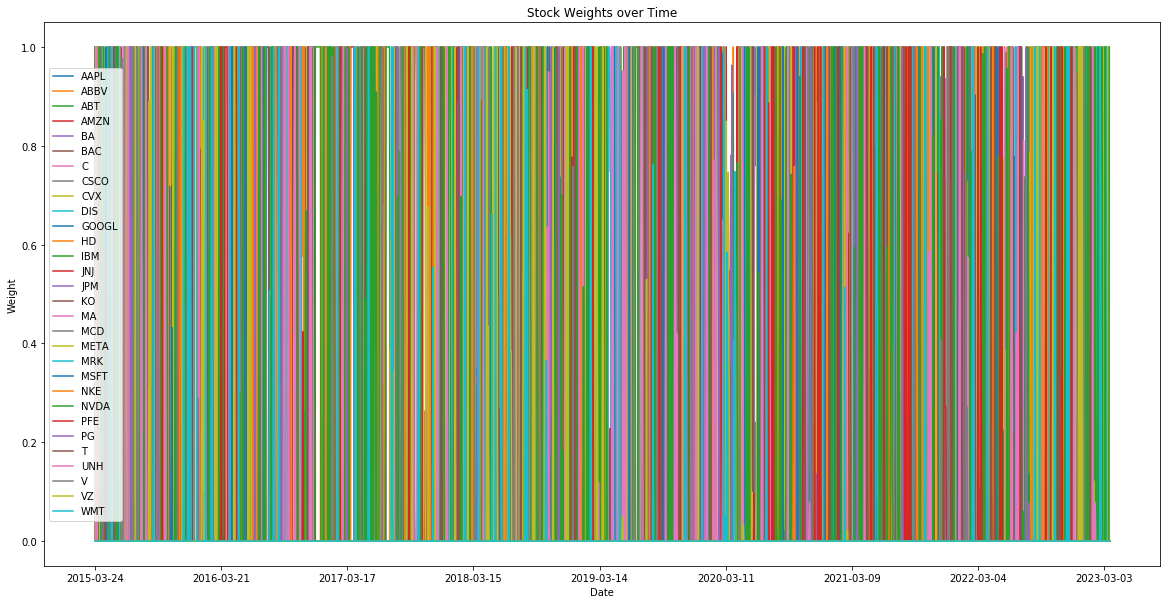

In [234]:
# Visualize the weight vector changes over time
signal.plot(figsize=(20, 10))  # Set the figure size
plt.title('Stock Weights over Time')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Weight')  # Set the y-axis label

In [238]:
# Benchmark - buy-and-hold
benchmark = actual_R_mat.copy()
benchmark['yield'] = benchmark.apply(lambda x: x.mean(), axis = 1)
benchmark['netvalue'] = benchmark['yield'].cumsum() + 1
benchmark.reset_index(inplace = True)
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

In [252]:
result = signal*return_matrix
result['yield'] = result.apply(lambda x: x.sum(), axis = 1)
result['netvalue'] = result['yield'].cumsum() + 1
# result['netvalue'] = (result['yield']+1).cumprod()
result['draw'] = np.maximum.accumulate(result['netvalue']) - result['netvalue']
result.reset_index(inplace = True)

In [253]:
result['Date'] = pd.to_datetime(result['Date'])
result['draw'] = (result['netvalue']-np.maximum.accumulate(result['netvalue']))
index_j = np.argmax(np.maximum.accumulate(result['netvalue']) - result['netvalue'])  # 结束位置
index_i = np.argmax(result['netvalue'][:index_j])  # 开始位置
index_dif = (result.Date[index_j] -  result.Date[index_i]).days
b = pd.to_datetime(result.Date.values[0])
e = pd.to_datetime(result.Date.values[-1])
years = (e-b).days/252
turnover = np.mean(signal.diff().abs().mean()) # BUG? (axis = 1)？
anyield = (result['netvalue'].iloc[-1]-1-len(signal)*turnover*0.0008/2)/years
maxdraw = np.min(result['draw'])
sharpe = round(result['yield'].mean()/result['yield'].std()*(np.sqrt(252)),4)
calmar = anyield/(-1*maxdraw)
print(maxdraw)
print('sharpe', sharpe)
print('calmar', calmar)

-0.189609219663474
sharpe 8.9989
calmar 12.161962499289245


In [254]:
costs = 0.0008 * np.concatenate((np.zeros(len(result.netvalue) - len(signal)+1), signal.diff().abs().sum(axis = 1)[1:]), axis = 0)

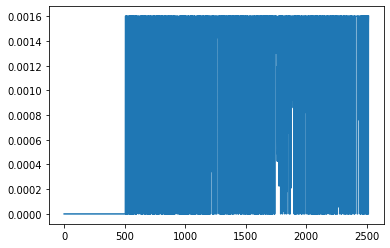

In [255]:
plt.plot(costs)

In [256]:
# return_matrix
target = (return_matrix['AAPL'] + return_matrix['NVDA'])/2
a = target.cumsum() + 1 

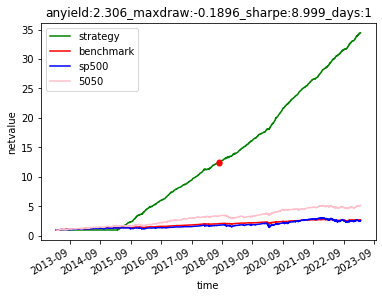

In [257]:
sp500['Date'] = pd.to_datetime(sp500['Date'])

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1)
axis.plot(result.Date,result.netvalue - costs, color = 'green', label = 'strategy')
axis.plot(benchmark.Date,benchmark.netvalue, color = 'red', label = 'benchmark')
axis.plot(sp500.Date,sp500.Close/sp500.Close.iloc[0], color = 'blue', label = 'sp500')
axis.plot(result.Date,a, color = 'pink', label = '5050')

axis.plot([result.Date[index_i], result.Date[index_j]], [result['netvalue'][index_i], result['netvalue'][index_j]], 'o', color="r", markersize=5)
axis.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))  #設置x軸主刻度顯示格式（日期）
axis.xaxis.set_major_locator(dates.MonthLocator(interval = 12))
for label in axis.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')
axis.set_title('anyield:'+str(round(anyield,3))+'_maxdraw:'+str(round(maxdraw,4))+'_sharpe:'+str(round(sharpe,3))+'_days:'+str(index_dif))
plt.xlabel('time')
plt.ylabel('netvalue')
plt.legend()
plt.show()